# Домашнее задание 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями
5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей
6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

1. Импорты и подгрузка датасета, небольшой анализ

In [14]:
# Подгружаем необходимые библиотеки:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import TwoModels

import random
import warnings

%matplotlib inline 
# встр команду логично копипастнуть в начало (сам себе напомнил)
warnings.filterwarnings('ignore') # игнорить предупреждения только из matplotlib

# Кстати пришлось обновлять и привязывать python 3.10, подгружать заново все библиотеки... люблю Linux

In [15]:
df = pd.read_csv('data.csv')

In [17]:
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


In [18]:
# Посмотрим информацию по нашему df:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


На первый взгляд в df отсутствуют пропуски, но это может быть не совсем так, там может быть 0 или 'нет', что не является nan, но и информации нам не даст.

In [19]:
# Посмотрим количественные показатели нашего df
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


И посмотрим на наши objects:

In [20]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

zip_code

zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64
****************************************************************************************************

channel

channel
Web             28217
Phone           28021
Multichannel     7762
Name: count, dtype: int64
****************************************************************************************************

offer

offer
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64
****************************************************************************************************



Без лупы (и пупы) заметен значительный дисбаланс классов в некоторых признаках. В реальной задаче его необходимо обработать, чтобы исключить перекосы в весах, но цель ДЗ- провести uplift-моделирование,  а посему предположим, что датасет чист и с ним можно работать. 

2. поле conversion - это целевая переменная (Целевая переменная — это переменная, которую необходимо объяснить или значения которой необходимо спрогнозировать в наборе прикладных данных), а offer - коммуникация (то, как мы взаимподействуем с клиентом). Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [21]:
#переименуем поля. inplace = True заменяет наименования в исходнике вместо создания нового df:
df.rename(columns = {'conversion':'target', 'offer':'treatment'}, inplace = True )

In [22]:
# Проверим что замена прошла успешно:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  object 
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Приведение поля treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
Поэтому замена при помощи df['имя'].replace, а далее- двумя списками в порядке очередности

In [23]:
df['treatment'] = df['treatment'].replace(['No Offer','Buy One Get One','Discount'],[0, 1, 1])
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
5,6,134.83,0,1,Surburban,0,Phone,1,1
6,9,280.20,1,0,Surburban,1,Phone,1,0
7,9,46.42,0,1,Urban,0,Phone,1,0
8,9,675.07,1,1,Rural,1,Phone,1,0
9,10,32.84,0,1,Urban,1,Web,1,0


3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), 
                                                    df['target'], random_state=42)
# отбрасывание target по оси=1 (столбец) и указание ее в качестве целевой переменной (y_train, y_test)

In [30]:
print(f"Классы в y_train:\n{y_train}")
print(f"Классы в y_test:\n{y_test}")

Классы в y_train:
7517     0
5343     0
35537    0
63983    0
45287    1
        ..
62570    0
38158    0
860      0
15795    0
56422    0
Name: target, Length: 48000, dtype: int64
Классы в y_test:
33042    0
7209     0
24367    0
19599    1
31465    1
        ..
37308    0
16162    0
23295    0
7789     0
27093    0
Name: target, Length: 16000, dtype: int64


4. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями

Одна модель с признаком коммуникации (S-learner):

In [31]:
# сохранение столбца "treatment" из train набора в одноименную переменную
train_treatment = X_train['treatment']
# сброс столбца "treatment" в обучающем наборе
X_train = X_train.drop('treatment', axis=1)

# те же самые операции для тестового набора
test_treatment = X_test['treatment']
X_test = X_test.drop('treatment', axis=1)

"\nТаким образом,\nмы сохраняем столбец 'treatment' из исходных обучающего и тестового наборов данных\nв отдельные переменные (train_treatment и test_treatment),\nа затем удаляем этот столбец из X_train и X_test,\nчтобы использовать их для обучения и тестирования моделей,\nисключив данный столбец как признак (features).\n\nОбожаю учитья у нейронок!\n"

Таким образом,
мы сохраняем столбец 'treatment' из исходных обучающего и тестового наборов данных
в отдельные переменные (train_treatment и test_treatment),
а затем удаляем этот столбец из X_train и X_test,
чтобы использовать их для обучения и тестирования моделей,
исключив данный столбец как признак (features).

Обожаю учитья у нейронок!

In [33]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

cat_features = ['zip_code', 'channel']

1. `models_results = {'approach': [], 'uplift@10%': [], 'uplift@20%': []}`: Здесь мы создаем пустой словарь с тремя ключами - 'approach' (подход), 'uplift@10%' (привышение на 10%) и 'uplift@20%' (привышение на 20%). Значениями для каждого ключа являются пустые списки. Таким образом, словарь `models_results` будет использоваться для хранения результатов моделей, включая информацию о подходе и значениях привлечения (эффекте) на 10% и 20%.

2. `cat_features = ['zip_code', 'channel']`: В этой строке кода мы создаем список `cat_features`, содержащий две строки - 'zip_code' (почтовый индекс) и 'channel' (канал). Этот список предполагает, что эти признаки (features) являются категориальными признаками.

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

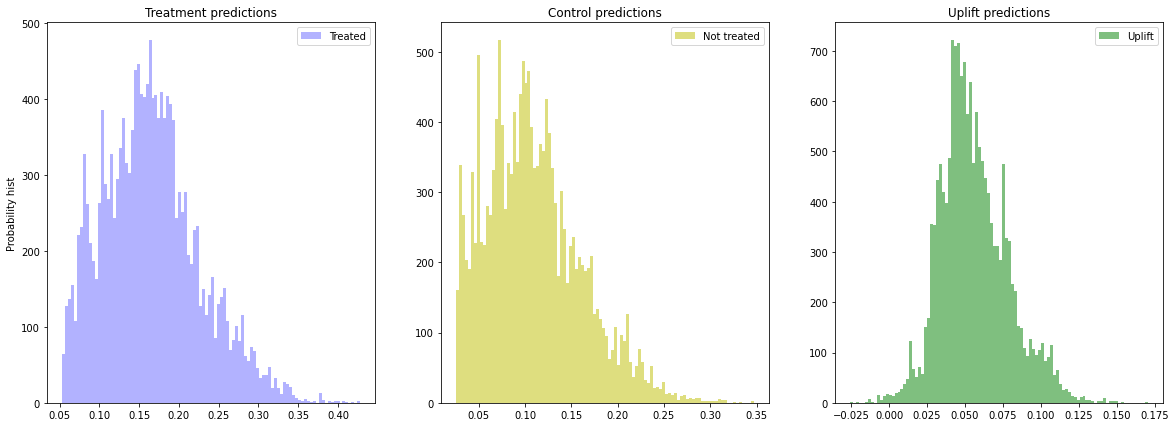

In [34]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, train_treatment)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=test_treatment, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=test_treatment, strategy='by_group', k=0.2)


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

Данная последовательность кода выполняет следующие действия:

1. `sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))`: Здесь мы создаем объект `sm` класса `SoloModel`. `SoloModel` - это модель для оценки привлекательности, или эффекта, для каждой единицы данных. Внутри `SoloModel` используется `CatBoostClassifier` с параметрами `iterations=20`, `random_state=42`, `silent=True` и `cat_features=cat_features`. `CatBoostClassifier` - это алгоритм градиентного бустинга, предназначенный для классификации. В данном случае он используется внутри `SoloModel` для моделирования привлекательности.

2. `sm = sm.fit(X_train, y_train, train_treatment)`: Здесь мы обучаем модель `sm` на обучающем наборе данных. `X_train` - это матрица признаков, `y_train` - это целевая переменная, а `train_treatment` - это столбец, содержащий информацию о назначении обработки.

3. `uplift_sm = sm.predict(X_test)`: Здесь мы используем обученную модель `sm`, чтобы предсказать привлекательность на тестовом наборе данных `X_test`. Результат сохраняется в `uplift_sm` - это массив предсказанных значений привлекательности для каждой единицы данных в `X_test`.

4. `sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=test_treatment, strategy='by_group', k=0.1)`: Здесь мы вычисляем оценку привлекательности на уровне 10% (`k=0.1`) с использованием функции `uplift_at_k`. В этом случае, `y_test` - это истинные значения целевой переменной на тестовом наборе данных, `uplift_sm` - это предсказанные значения привлекательности для тестового набора данных, `test_treatment` - это столбец, содержащий информацию о назначении обработки, `strategy='by_group'` означает разделение на три группы на основе привлекательности, и результат сохраняется в `sm_score_10`.

5. `sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=test_treatment, strategy='by_group', k=0.2)`: Здесь мы вычисляем оценку привлекательности на уровне 20% (`k=0.2`) с использованием функции `uplift_at_k`. Аргументы функции аналогичны предыдущей строке кода, и результат сохраняется в `sm_score_20`.

6. `models_results['approach'].append('SoloModel')`: Здесь мы добавляем значение 'SoloModel' в список, хранящий подходы моделирования в словаре `models_results`.

7. `models_results['uplift@10%'].append(sm_score_10)`: Здесь мы добавляем значение `sm_score_10` (оценка привлекательности на уровне 10%) в список `uplift@10%` в словаре `models_results`.

8. `models_results['uplift@20%'].append(sm_score_20)`: Здесь мы добавляем значение `sm_score_20` (оценка привлекательности на уровне 20%) в список `uplift@20%` в словаре `models_results`.

9. `sm_trmnt_preds = sm.trmnt_preds_`: Здесь мы получаем прогнозы модели `sm` для обработанных наблюдений, сохраняем их в `sm_trmnt_preds`.

10. `sm_ctrl_preds = sm.ctrl_preds_`: Здесь мы получаем прогнозы модели `sm` для контрольных наблюдений, сохраняем их

Модель с трансформацией таргета:

In [35]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, train_treatment)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=test_treatment, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=test_treatment, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

Данная последовательность кода выполняет следующие действия:

1. `ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))`: Здесь мы создаем объект `ct` класса `ClassTransformation`. `ClassTransformation` - это модель для оценки привлекательности, или эффекта, для каждой единицы данных с использованием преобразования классов. Внутри `ClassTransformation` используется `CatBoostClassifier` с параметрами `iterations=20`, `random_state=42`, `silent=True` и `cat_features=cat_features`.

2. `ct = ct.fit(X_train, y_train, train_treatment)`: Здесь мы обучаем модель `ct` на обучающем наборе данных. `X_train` - это матрица признаков, `y_train` - это целевая переменная, а `train_treatment` - это столбец, содержащий информацию о назначении обработки.

далее аналогично uplift c коэффициентами 10 и 20%, см выше в SoloModel!!

В результате выполнения этого кода, оценки привлекательности `ct_score_10` и `ct_score_20` на уровнях 10% и 20% добавляются в словарь `models_results` для моделирования привлекательности с использованием классового преобразования

Две независимые модели:

In [36]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, train_treatment
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=test_treatment, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=test_treatment, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

Данная последовательность кода выполняет следующие действия:

1. `tm = TwoModels(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features), CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features), method='vanilla')`: Здесь мы создаем объект `tm` класса `TwoModels`. `TwoModels` - это модель для оценки привлекательности, или эффекта, для каждой единицы данных с использованием двух независимых моделей. Внутри `TwoModels` используются две копии `CatBoostClassifier` с параметрами `iterations=20`, `random_state=42`, `silent=True` и `cat_features=cat_features`. Каждая модель в `TwoModels` будет обучаться независимо от другой модели на одних и тех же обучающих данных. Параметр `method='vanilla'` указывает, что используются две независимые модели.

2. `tm = tm.fit(X_train, y_train, train_treatment)`: Здесь мы обучаем модель `tm` на обучающем наборе данных. `X_train` - это матрица признаков, `y_train` - это целевая переменная, а `train_treatment` - это столбец, содержащий информацию о назначении обработки.

3. `uplift_tm = tm.predict(X_test)`: Здесь мы используем обученную модель `tm`, чтобы предсказать привлекательность на тестовом наборе данных `X_test`. Результат сохраняется в `uplift_tm` - это массив предсказанных значений привлекательности для каждой единицы данных в `X_test`.

скоринг по процентам и добавление в словарь смотри выше

5 пункт, вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [37]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.135178,0.112432
1,ClassTransformation,0.130616,0.109236
2,TwoModels,0.115410,0.095982


В приведенных результатах оценки привлекательности для разных подходов в моделировании есть три различных подхода: SoloModel, ClassTransformation и TwoModels. Каждый подход имеет свои оценки привлекательности на уровнях 10% и 20%.

- SoloModel имеет оценку привлекательности 0.135178 на уровне 10% и 0.112432 на уровне 20%.
- ClassTransformation имеет оценку привлекательности 0.130616 на уровне 10% и 0.109236 на уровне 20%.
- TwoModels имеет оценку привлекательности 0.115410 на уровне 10% и 0.095982 на уровне 20%.

На основе этих результатов можно сделать некоторые выводы о привлекательности различных подходов в моделировании. SoloModel показывает самый высокий уровень оценки привлекательности для обоих уровней - 10% и 20%. ClassTransformation и TwoModels показывают немного более низкие оценки привлекательности на обоих уровнях по сравнению с SoloModel. 

Однако стоит отметить, что результаты оценки привлекательности могут различаться в зависимости от данных, моделирования и выбранной метрики оценки. Поэтому важно принимать во внимание не только числовые значения оценок, но и контекст и особенности конкретной задачи.

*для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [57]:
# Загрузка тестовой выборки копированием в новую переменную
X_test_w_uplift = X_test.copy()

# Получение значений uplift из модели S-learner и отброшенных conversion
uplift_values = uplift_sm
conversion_values = y_test

# Создание столбцов "uplift" и "conversion" в копии тестовой выборки (важно чтобы не были перемешаны)
X_test_w_uplift['uplift'] = uplift_values
X_test_w_uplift['conversion'] = conversion_values

# Вывод обновленной тестовой выборки с привязанными значениями uplift
X_test_w_uplift.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift,conversion
33042,9,64.85,1,0,Surburban,1,Web,0.038234,0
7209,1,144.12,0,1,Urban,0,Web,0.092319,0
24367,1,734.25,0,1,Surburban,1,Phone,0.074673,0
19599,4,1321.26,1,0,Surburban,1,Multichannel,0.051227,1
31465,2,261.23,1,1,Surburban,1,Web,0.110499,1
32504,6,290.33,0,1,Urban,0,Phone,0.053331,0
23080,5,55.56,0,1,Urban,0,Phone,0.063488,1
7168,11,76.11,1,0,Surburban,1,Phone,0.031164,0
26195,6,29.99,1,0,Surburban,0,Phone,0.036646,0
36096,11,260.92,1,0,Rural,0,Phone,0.024542,0


In [58]:
X_test_w_uplift_sorted = X_test_w_uplift.sort_values(by='uplift', ascending=False)
X_test_w_uplift_sorted.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift,conversion
52596,1,268.73,1,1,Rural,1,Web,0.170652,0
26533,1,228.42,1,1,Surburban,1,Web,0.154139,1
38313,1,245.94,1,1,Surburban,1,Web,0.150892,0
5525,1,267.61,1,1,Surburban,1,Web,0.150892,0
27441,1,245.75,1,1,Surburban,1,Web,0.150892,1
46748,1,289.57,1,1,Surburban,1,Web,0.149060,0
60018,1,265.11,1,1,Rural,1,Multichannel,0.148181,0
53863,1,285.74,1,1,Surburban,1,Phone,0.147290,1
52137,1,262.68,1,1,Surburban,1,Phone,0.147290,0
31570,1,257.68,1,1,Surburban,1,Phone,0.147290,1


In [63]:
# Разбить на децили с помощью pandas qcut
X_test_w_uplift_sorted['decile'] = pd.qcut(X_test_w_uplift_sorted['uplift'], 10, labels=False)
X_test_w_uplift_sorted

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift,conversion,decile
52596,1,268.73,1,1,Rural,1,Web,0.170652,0,9
26533,1,228.42,1,1,Surburban,1,Web,0.154139,1,9
38313,1,245.94,1,1,Surburban,1,Web,0.150892,0,9
5525,1,267.61,1,1,Surburban,1,Web,0.150892,0,9
27441,1,245.75,1,1,Surburban,1,Web,0.150892,1,9
...,...,...,...,...,...,...,...,...,...,...
57426,1,29.99,1,0,Rural,0,Phone,-0.012995,0,0
54780,1,275.96,1,0,Rural,0,Phone,-0.014183,0,0
10930,1,269.48,1,0,Rural,0,Phone,-0.014183,0,0
28691,1,481.43,1,0,Rural,0,Web,-0.021596,0,0


In [65]:
# Для каждого дециля посчитать среднюю conversion
avg_target_by_decile = X_test_w_uplift_sorted.groupby('decile')['conversion'].mean()
print(avg_target_by_decile)

decile
0    0.110418
1    0.105197
2    0.119850
3    0.136449
4    0.132288
5    0.132959
6    0.150719
7    0.162805
8    0.166563
9    0.231058
Name: conversion, dtype: float64


по полученным результатам можно сделать очевидный вывод, что чем выше uplift в дециле, тем выше шанс коммуникации.
Прямая зависимость. Доклад закончил